In [16]:
# Google Colab does not have with ipympl installed. This doesn't allow for
# interactive figures. Decomment the following code if you wish to run this
# notebook in Google Colab.

'''

!pip install -q ipympl

from google.colab import output
output.enable_custom_widget_manager()

'''

'\n\n!pip install -q ipympl\n\nfrom google.colab import output\noutput.enable_custom_widget_manager()\n\n'

In [2]:
# If figures aren't showing, try %matplotlib notebook
%matplotlib widget

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import widgets, Layout, Label, HBox, VBox

# Bifurcations with two parameters - Fish

## Prologue

This is the second exercise of *Biophysics Assignment 1*. For the first exercise, see the notebook called *Biophysics_Assignment_1_E1*. References to the Notes section are written as [0].

## Problem Statement

The following differential equation models a fish population in a fish pound.

$N' = rN(1 - \frac{N}{K}) - H \frac{N}{A + N}$

with $A \le K$ and $A, K, r, H > 0$.

**Question 1**: Rewrite in dimensionless form.

Set $x = N/K$ the fraction of the max. population [1] of fish, $\tau = rt$ a sort of time in terms of the reproduction rate. Also $a = A/K$ and $h = H/rK$. The following is true (chain rule).

$\frac{dx}{d\tau} = \frac{dx}{dN}\frac{dN}{dt}\frac{dt}{d\tau} = \frac{1}{rK}N'$

Substitute $N'$.

$\frac{dx}{d\tau} = x(1 - x) - h \frac{x}{a + x}$

This is the differential equation we will work with.

**Question 2**: Create a 2D map, where you present the number of equilibra depending on the parameters $h$ and $a$. What do you see?

**Question 3**: Now take $a = [0.1, 0.2, ..., 1]$ and for each value of $a$, let $h$ vary. What type of bifurcations do you see? Did you expect this from the previous map? How do you see the evolution of these bifurcation for increasing $a$?

**Question 4**: Make a 3D picture of the equilibria. Plot only the positive values of $x$ (as negative fish do not exist). What can you conclude?

**Question 5**: Explain where the tipping points in your system are, and give a physical interpretation of your system.

## Solution

OUTLINE

---

The code for questions 2 - 4 is written here all at once. As in the first exercise, functions are categorised into calculation oriented and plot oriented functionalities. Further on, there are some more general plot functions designed for the way figures display the information (this will get clearer as we go through the code). Figures are shown all the way at the bottom, as well as their explanation.

CONSTANTS / COLORS / COLORMAPS

---

The following code cell defines the constants. Most of these are used for aesthetic reasons. As for the specific implementation of these constants, see the comments.

In [3]:
MAX_EQUILIBRIA = 3

# colors for bifurcation diagram
C_STABLE = 'blue'
C_UNSTABLE = 'red'

# colors for the 3D plot [2, 3]
COLORS_STABLE = [
    (0.06274509803921569, 0.22745098039215686, 0.5764705882352941),
    (0.4235294117647059, 0.5843137254901961, 0.9372549019607843)
]

COLORS_UNSTABLE = [
    (0.6470588235294118, 0.07058823529411765, 0.07058823529411765),
    (0.9411764705882353, 0.4235294117647059, 0.4235294117647059)
]

# colors for the 2D map (color plot) [2]
COLORS_CPLOT = [
    (0.06274509803921569, 0.30980392156862746, 0.3333333333333333),
    (0.16470588235294117, 0.43529411764705883, 0.43529411764705883),
    (0.2, 0.5254901960784314, 0.5254901960784314),
]

# colormaps
COLORMAP_STABLE = mpl.colors.LinearSegmentedColormap.from_list(
    'COLORMAP_STABLE',
    COLORS_STABLE,
    N=100
)
COLORMAP_UNSTABLE = mpl.colors.LinearSegmentedColormap.from_list(
    'COLORMAP_UNSTABLE',
    COLORS_UNSTABLE,
    N=100
)
COLORMAP_CPLOT = mpl.colors.LinearSegmentedColormap.from_list(
    'COLORMAP_CPLOT',
    COLORS_CPLOT,
    N=3
)

In [4]:
# assigns a color to values of X via a stability indexing array [3]

@staticmethod
def get_stability_colors(X, stability_idx):
    norm_stable = mpl.colors.Normalize(
        vmin=np.min(X[stability_idx]),
        vmax=np.max(X[stability_idx])
    )
    norm_unstable = mpl.colors.Normalize(
        vmin=np.min(X[~stability_idx]),
        vmax=np.max(X[~stability_idx])
    )
    sm_stable = mpl.cm.ScalarMappable(
        norm=norm_stable,
        cmap=COLORMAP_STABLE
    )
    sm_unstable = mpl.cm.ScalarMappable(
        norm=norm_unstable,
        cmap=COLORMAP_UNSTABLE
    )

    C = sm_unstable.to_rgba(X)
    C[stability_idx] = sm_stable.to_rgba(X[stability_idx])

    return C

CALCULATIONS

---

We can see off the bat that $x = 0$ is an equilibrium. The other 2 equilibria were then easily calculated by finding the roots of a quadratic polynomial. The function *get_equilibria* returns those equilibria for a given $a$ and $h$.

In [5]:
def get_x_prime(x, a, h):
    x_prime = x * (1 - x) - h * x / (a + x)
    return x_prime

# make sure (a, h) is complex, or python gives Runtimewarning
def get_equilibria(a, h):
    equilibria = np.array([
        np.zeros(np.array(h).shape), # makes sure function returns matrix
        -(a - 1)/2 - np.sqrt(a**2 + 2*a - 4*h + 1)/2,
        -(a - 1)/2 + np.sqrt(a**2 + 2*a - 4*h + 1)/2
    ])
    return equilibria

def is_stable(eq, a, h, tol=0.001):
    return get_x_prime(eq + tol, a, h) < 0

SPECIFIC PLOT FUNCTIONS

---

In [6]:
# 2D color map of the number of equilibria
def plot_color_equilibria(ax, A, H):
    X = get_equilibria(A, H)

    # count amount of real equilibria
    C = np.count_nonzero((np.imag(X) == 0), axis=0)

    # when a = h there are duplicate equilibria
    # this code will only work if A[0, 0] == H[0, 0] [4]
    np.fill_diagonal(C, np.diagonal(C) - 1)

    cplot = ax.pcolormesh(
        A.real, H.real, C, cmap=COLORMAP_CPLOT, vmin=0.5, vmax=3.5
    )

    return cplot

def plot_3d_equilibria(ax, A, H, size):
    X = get_equilibria(A, H)
    X[np.real(X) < 0] = np.nan
    X[np.imag(X) != 0] = np.nan

    # arrays of the same size as X are created to call plt.scatter3D once
    A_3D = np.full((MAX_EQUILIBRIA, *np.shape(A)), A)
    H_3D = np.full((MAX_EQUILIBRIA, *np.shape(H)), H)

    # an indexing array to indicate real, positive equilibria
    idx = (~np.isnan(X))
    A_real = A_3D[idx].real
    H_real = H_3D[idx].real
    X_real = X[idx].real

    stable = is_stable(X_real, A_real, H_real)
    C = get_stability_colors(X_real, stable)

    scatter = ax.scatter3D(A_real, H_real, X_real, 'z', size, C)

    return scatter

# bifurcation diagram for a fixed a
def plot_equilibria_fixed_a(ax, a, hmin, hmax, hstep=0.001):
    H_1D = np.arange(hmin, hmax, hstep, dtype=complex)

    # an array of the same size as X is created to call plt.scatter once
    H = np.full((MAX_EQUILIBRIA, H_1D.size), H_1D)
    X = get_equilibria(a, H_1D)

    real_idx = (np.imag(X) == 0)
    H_real = H[real_idx].real
    X_real = X[real_idx].real

    stable = is_stable(X_real, a, H_real)
    C = np.full(X_real.size, C_UNSTABLE, dtype=str)
    C[stable] = C_STABLE
    scatter = ax.scatter(H_real, X_real, 0.1, C)

    ax.set_ylim(np.min(X_real), np.max(X_real))

    return scatter

def plot_stability_arrows_fixed_a(ax, H, a):
    quivers = []
    for h in H:
        X = get_equilibria(a, h)
        X_real = X[np.imag(X) == 0].real

        for x in X_real:
            stable = is_stable(x, a, h)
            pivot = 'tip' if stable else 'tail'
            quivers.append(
                ax.quiver(
                    h.real, x, 0, 1, color='black', pivot=pivot,
                    width=0.005, minlength=3
                )
            )
            quivers.append(
                ax.quiver(
                    h.real, x, 0, -1, color='black', pivot=pivot,
                    width=0.005, minlength=3
                )
            )

    return quivers

GENERAL PLOT FUNCTIONS

---

In [7]:
# make sure amin = hmin (to correct the diagonal in cplot)
amin, amax = 0, 1.5
hmin, hmax = 0, 2
hrange = (hmax - hmin)

# array of values to plot stability arrows
H_arrows = np.linspace(hmin + hrange/4, hmax - hrange/4, 2, dtype=complex)

# lists used for resolution widget
RS = [('Low', 0.02), ('Medium', 0.0075), ('High', 0.001)]
RS_3D = [('Low', 0.05), ('Medium', 0.01), ('High', 0.0025)]

In [8]:
# keeps track of what is currently being shown
config = {
    'cplot': None,
    'lines': [],
    'lines_3d': None,
    'resolution': RS[0][1],
    'resolution_3d': RS_3D[0][1],
    'fixed_a': 1,
    'arrows': True,
}

def update_config(
    resolution=None,
    resolution_3d=None,
    fixed_a=None,
    arrows=None
):
    if resolution is not None:
        config['resolution'] = resolution
    if resolution_3d is not None:
        config['resolution_3d'] = resolution_3d
    if fixed_a is not None:
        config['fixed_a'] = fixed_a
    if arrows is not None:
        config['arrows'] = arrows
    return

The cell below contains the 3 main functions for plotting.

In [9]:
# 2D map (color plot)
def plot_cplot(resolution):
    A, H = np.meshgrid(
        np.arange(amin, amax + resolution, resolution, dtype=complex),
        np.arange(hmin, hmax + resolution, resolution, dtype=complex)
    )

    config['cplot'] = plot_color_equilibria(axs[0], A, H)
    return

def plot_bifurcation(a, arrows):
    config['lines'].append(
        axs[1].text(0, 1.05, f'a = {a}')
    )
    config['lines'].append(
        plot_equilibria_fixed_a(axs[1], a, hmin, hmax)
    )
    config['lines'].append(
        axs[0].axvline(a, color='white', linestyle='dashed')
    )

    if arrows:
        config['lines'].append(
            plot_stability_arrows_fixed_a(axs[1], H_arrows, a)
        )

    return

def plot_3d(resolution_3d):
    A, H = np.meshgrid(
        np.arange(amin, amax + resolution_3d, resolution_3d, dtype=complex),
        np.arange(hmin, hmax + resolution_3d, resolution_3d, dtype=complex)
    )

    config['lines_3d'] = plot_3d_equilibria(ax_3d, A, H, 10 * resolution_3d)
    return

In [10]:
def clear_bifurcation():
    for line in config['lines']:
        try:
            line.remove()
        except:
            [l.remove() for l in line]

    config['lines'] = []
    return

def update_bifurcation(fixed_a, arrows):
    clear_bifurcation()
    update_config(fixed_a=fixed_a, arrows=arrows)
    plot_bifurcation(fixed_a, arrows)
    return

In [11]:
# should only be called once, function is created to improve code readability
def decorate_plots():
    axs[0].set_xlabel('a')
    axs[0].set_ylabel('h')
    axs[0].set_title('Color plot of the number of equilibria')
    axs[0].set_xlim(amin, amax)
    axs[0].set_ylim(hmin, hmax)

    fig.colorbar(
        config['cplot'], ax=axs[0], ticks=np.arange(4), label='# Equilibria'
    )

    axs[1].set_xlabel('h')
    axs[1].set_ylabel('equilibria x')
    axs[1].set_xlim(hmin, hmax)

    # labels for bifurcation diagram (stable and unstable)
    label_lines = [
        mpl.lines.Line2D([0], [0], color=C_STABLE),
        mpl.lines.Line2D([0], [0], color=C_UNSTABLE)
    ]
    axs[1].legend(label_lines, ['stable', 'unstable'])

    return

Below are handlers for the widgets.

In [12]:
def on_rs_change(source):
    rs = source['new']
    config['cplot'].remove()
    update_config(resolution=rs)
    plot_cplot(rs)
    return

def on_fixed_a_change(source):
    a = source['new']
    update_bifurcation(a, config['arrows'])
    return

def on_arrows_change(source):
    arrows = source['new']
    update_bifurcation(config['fixed_a'], arrows)
    return

def on_rs_3d_change(source):
    rs = source['new']
    config['lines_3d'].remove()
    update_config(resolution_3d=rs)
    plot_3d(rs)
    return

In [13]:
# buttons to choose the resolution of the color plot
resolution_btns = widgets.ToggleButtons(
    options=RS,
    value=config['resolution'],
    description='',
    button_style='info',
    layout=Layout(padding='2px'),
    disabled=False,
    continuous_update=False
)

# slider for bifurcation diagram
a_slider = widgets.FloatSlider(
    value=config['fixed_a'],
    min=amin,
    max=amax,
    step=0.1,
    description='a',
    layout=Layout(width='400px'),
    slider_color='blue',
    disabled=False,
    continuous_update=False
)

# checkbox to display stability arrows
arrows_checkbox = widgets.Checkbox(
    value=config['arrows'],
    description='Display Stability Arrows',
    layout=Layout(width='180px'),
    indent=False,
    disabled=False
)

# buttons to choose the resolution of the 3D plot
resolution_3d_btns = widgets.ToggleButtons(
    options=RS_3D,
    value=config['resolution_3d'],
    description='',
    button_style='info',
    layout=Layout(padding='2px'),
    disabled=False,
    continuous_update=False
)

# add listeners to widgets
resolution_btns.observe(on_rs_change, names='value')
a_slider.observe(on_fixed_a_change, names='value')
arrows_checkbox.observe(on_arrows_change, names='value')
resolution_3d_btns.observe(on_rs_3d_change, names='value')

2D MAP / BIFURCATION DIAGRAM

---

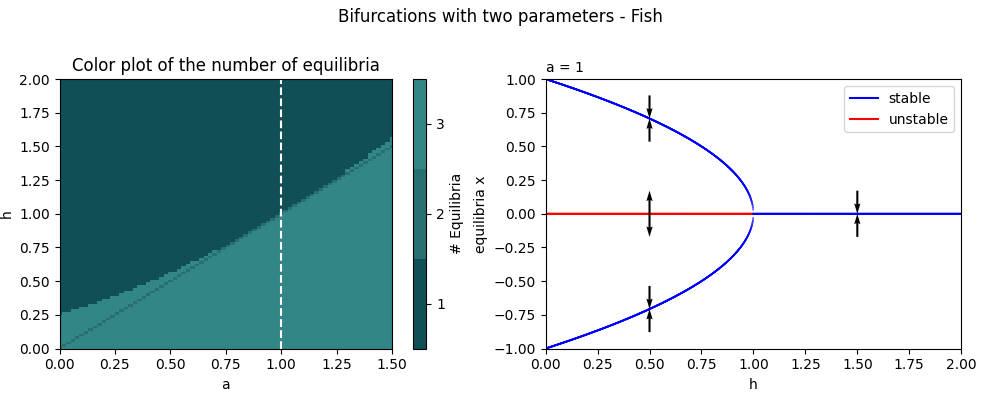

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
fig.suptitle('Bifurcations with two parameters - Fish')
plt.tight_layout(pad=2)

plot_cplot(config['resolution'])
plot_bifurcation(config['fixed_a'], config['arrows'])
decorate_plots()

# widgets
rs_label = Label(
    'Resolution settings (left plot only).\
    \'Low\' is recommended for fast plotting.',
    layout = Layout(width='528px')
)

VBox([
    HBox([resolution_btns, a_slider]),
    HBox([rs_label, arrows_checkbox])
])

The figure above displays the 2D map of the number of equilibria (left). The dashed line depicts the 'slice' of which the bifurcation diagram is plotted (right). It fixes a value of $a$ in place and lets $h$ vary. Arrows are plotted to indicate the stability of equilibria, but this is also reflected in their color.

The resolution of the 2D map can be adjusted via the blue buttons. The $a$ value for which the bifurcation diagram is plotted can be chosen via a slider. Finally, the stability arrows can be toggled on or off.

Answer for Q2

---

The following are regions of interest:
* When $a = h$, there are only 2 equilibria.
* The dark blue color describes the region of 1 equilibrium. We can see that, for a given $a$, $h$ needs to be sufficiently large for there to be only 1 equilibrium.
* The lightest color depicts the region of 3 equilibria (this is the rest of the map).

How these equilibria arise can be better understood with the aid of the bifurcation diagram.

Answer for Q3

---

For values of $a < 1$, we observe a trend. We start off with 3 equilibria, where $x = 0$ is unstable. When $h$ reaches the value of $a$, the bottom 2 equilibria collide and exchange stability ($x = 0$ becomes unstable). This is a transcritical bifurcation, and was to be expected when we looked at the 2D map, since only 2 equilibria exist at that point. For a slightly higher value of $h$, again 2 equilibria collide but this time they annihilate each other. This is a saddle node bifurcation. This could have also been deduced from the 2D map, where 3 equilibria turn into 1.

When $a = 1$, something interesting happens. It again starts off as 3 equilibria, but this time when $h = a$, all 3 equilibria collide and turn into one stable equilibrium $x = 0$. This is a pitchfork bifurcation, where indeed $x = 0$ switches from unstable to stable.

The bifurcation diagrams for values of $a > 1$, are analogous to $a < 1$. The only difference is that the transcritical bifurcation happens for the upper 2 equilibria (instead of the lower 2).

It is clear that, as $a$ approaches $1$, two bifurcations turn into one pitchfork bifurcation. You could see this as a sort of merging between the transcritical and saddle node bifurcations.

The nice thing about having a slider for the value of $a$, and a dashed line on the 2D map depicting the 'slice', is that you can really follow along what happens to the equilibria as $h$ increases.

3D PICTURE

---

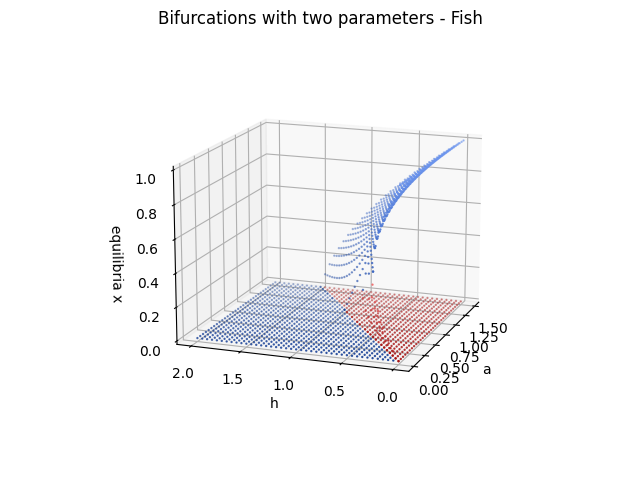

In [15]:
fig_3d, ax_3d = plt.subplots(subplot_kw={"projection": "3d"})
fig_3d.suptitle('Bifurcations with two parameters - Fish')

ax_3d.view_init(15, -160)
ax_3d.set_xlabel('a')
ax_3d.set_ylabel('h')
ax_3d.set_zlabel('equilibria x')
ax_3d.set_zlim(bottom=0)

plot_3d(config['resolution_3d'])

# widgets
rs_3d_label = Label(
    'Resolution settings.\
    \'Low\' is recommended for fast plotting.',
)

VBox([
    HBox([resolution_3d_btns]),
    HBox([rs_3d_label])
])

The figure above displays the 3D picture of the equilibria (where only positive values of $x$ are shown). The resolution settings can be adjusted via the buttons, although high resolution is not recommended if you wish to rotate the plot.

Answer for Q4

---

We can see that the region of one equilibrium ($x = 0$) is stable. However, since negative fish are not physically allowed, the number of equilibria will differ from the 2D map. A small region can be observed where 3 equilibria exist. The bottom and top equilibria are both stable, the middle one is unstable. This region corresponds to the region between the transcritical and saddle node bifurcation. When the 'transcritical line' is passed, only 2 equilibria exist, whereby the top equilibrium stays stable and $x = 0$ becomes unstable.

The bifurcations can now be interpreted as 3D lines. The transcritical line, is that line for which the equilibrium $x = 0$ switches stability. It is the line $(a, h, x) = (r, r, 0)$ with $r$ a free parameter. The saddle node line is a bit more complicated, and only exists for $a < 1$. The pitchfork bifurcation at $(1, 1, 0)$ is no longer visible, because $x \ge 0$.

Answer for Q5

---

The saddle node line corresponds to the tipping points. Say the system is in the region with more than 1 equilibrium, and it's currently in the upper, stable equilibrium. A small decrease in either $a$ or $h$ makes the equilibrium jump to $x = 0$. Let's explain this a bit more physically.

$x$ is the population of fish (technically the fraction of the max. population). And let's say $a < 0.4$ is fixed, so that the bifurcation diagram can help us understand it (where we only consider $x > 0$). The x-axis depicts the parameter $h$, which could be interpreted as the rate of fishing. Suppose $h$ is small (say $0.25$), and the system is in stable equilibrium. This means the fish population won't change over time. If we now increase the fishing rate by just a tiny bit, the system will evolve to a new stable equilibrium.

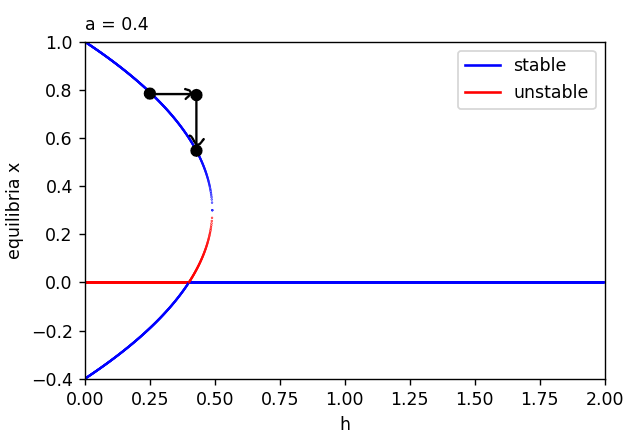

Increase the rate of fishing by too much however, past the tipping point, and the equilibrium jumps to $x = 0$ and thus the fish population crashes.

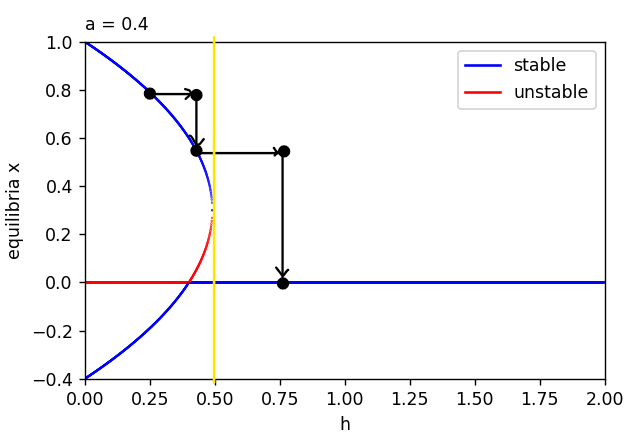

Notice how, if we reduce the rate of fishing again, the system doens't necessarily revert to its original state. This is called hysteresis, where the state of a system depends on its history.

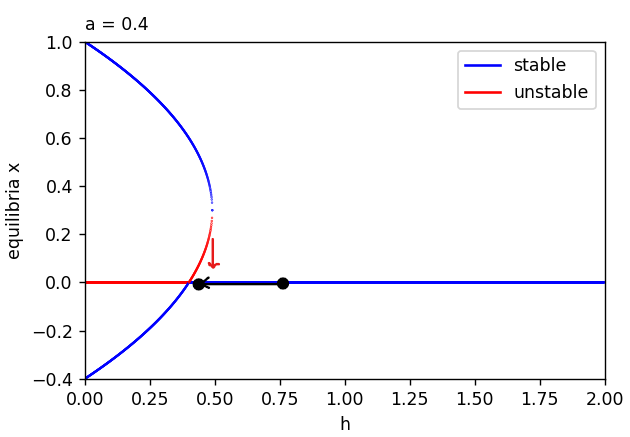

We would have to decrease the fishing rate by more to get back to a population ($> 0$) in stable equilibrium. In the 3D picture, this means we would have to go past the transcritical line (where $x = 0$ becomes unstable again).

The rate of catching fish doesn't only depend on how much is fished ($h$), but also on how many fish are in the pound. This is why $a$ was introduced; one can get proportionally less fish if the population of fish isn't that large. $a$ represents how large the population has to be in order for more fish to be caught. A larger value of $a$ means you can safely fish more ($h$ can be larger), without making the population crash.

An interpretation of $a$ could be the following. $a$ could represent how sophisticated the fish are, i.e. how likely they are (not) to catch the bait. Another interpretation could be the depth at which fish like to swim, which means they're again less likely to get caught.

## Epilogue

EXAMPLE 1

---

[This article](https://www.theguardian.com/environment/2023/oct/25/climate-crisis-threatens-tipping-point-of-uninsurable-homes-says-un#:~:text=The%20climate%20tipping%20points%20are,complex%20social%20and%20ecological%20systems.) from the 25th of October is about 'risk tipping points', which differ from the huge climate tipping points by the fact that these are *more directly connected to people's lives via complex social and ecological systems*. The gist of a tipping point is the same, in the sense that a small change in parameters (the *driving force*) leads to large, irreversible impacts.

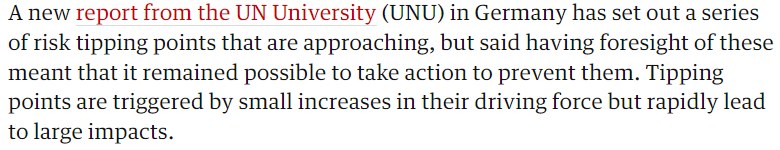

The article talks more about the effects of, and tipping points created by, the ongoing climate crisis. One example they give is about groundwater aquifers from which water is extracted by a well.

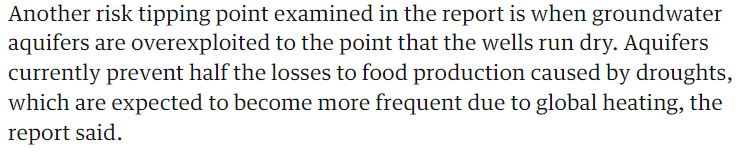

If these would suddenly dry up, this would lead to a massive failure in food production, of which the effects would be irreversible.

EXAMPLE 2

---

An important point which has to be addressed, is the fact that this 'jumping' to another equilibrium doesn't happen instantaniously. Our climate doesn't necessarily have to be in equilibrium. Once a tipping point is crossed, the system will simply evolve to another equilibrium. The timescale on which this evolution takes place however, isn't always certain.

[This article](https://en.wikipedia.org/wiki/Tipping_points_in_the_climate_system) from Wikipedia does a great job at explaining climate tipping points.

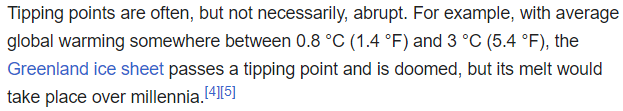

However, it's important to understand that abrupt changes are still possible.

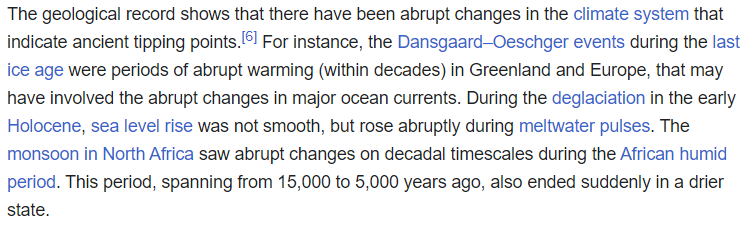

Some of these tipping points (but not all) are bifurcation induced, similar to the fish model.

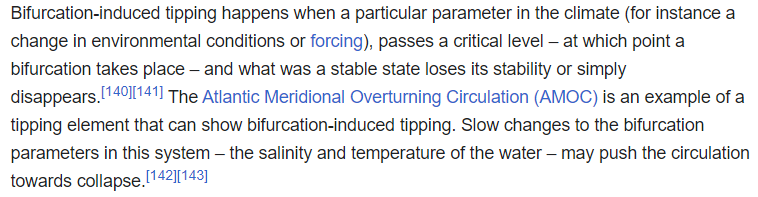

The article gives a lot more examples of tipping points than are given here, and it's really worth taking a look at. A specific example of a tipping point induced by a saddle node bifurcation, has to do with the *Atlantic Meridional Overturning Circulation* (see [this article](https://en.wikipedia.org/wiki/Atlantic_meridional_overturning_circulation)).

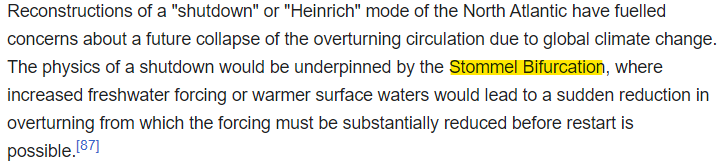

EXAMPLE 3

---

[This article](https://www.science.org/doi/10.1126/science.abn7950) in *Science* covers 9 global and 7 regional tipping elements which impact human welfare and the Earth system as a whole. They define tipping points as follows:

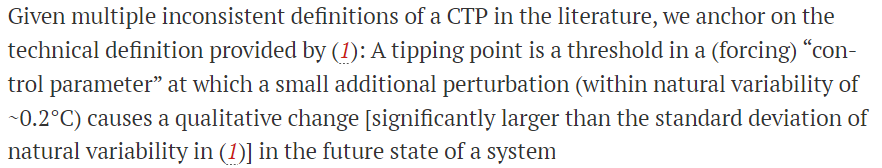

One example of a tipping element they give is (again) the *Greenland Ice Sheet (GrIS)*. Notice how the critical thresholds they give are in agreement with the article from Wikipedia.

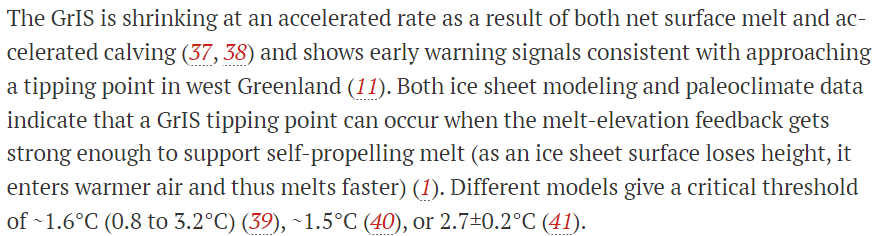

# Notes

[0] This is an example note.

---

[1] $K$ represents the maximum number of fish. If $N$ exceeds $K$, the population will start to decline.

---

[2] Rgb colors were chosen with the aid of *coolors.co*.

---

[3] For the 3D plot, instead of assigning just one color to stable equilibria and one color to unstable equilibria, a color gradient is assigned. This improves visibility (allows to see depth) in the 3D plot.

---

[4] The calculation of the number of equilibria is written in the way it is for performance reasons (fast plotting). It could have also been calculated with for loops, but (for high resolution, i.e. big A and H matrices) this would have been significantly slower. Here, speed was preferred over generality.